<a href="https://colab.research.google.com/github/kavitalolayekar/HR_Analytics_Employee_Churn_Prediction-/blob/main/CycleGAN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Style Transfer Using GAN**

In [ ]:
import os
from os import listdir
import numpy as np 
import matplotlib.pyplot as plt
% matplotlib inline
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imprting data and Resizing !

In [ ]:
def import_img(path,size = (256,256)):
  data_list = list()

  for filename in listdir(path):
    pixel = load_img(path+filename,target_size=size)
    pixel = img_to_array(pixel)
    data_list.append(pixel)
  return asarray(data_list)


In [ ]:
tnsr_data1 = import_img("/content/drive/MyDrive/MRI+T1_T2+Dataset/Tr1/TrainT1/")
tnsr_data1 = tf.image.rgb_to_grayscale(tnsr_data1)
tnsr_data1 = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tnsr_data1))
tnsr_data1

<TensorSliceDataset element_spec=TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)>

In [ ]:
tnsr_data2 = import_img("/content/drive/MyDrive/MRI+T1_T2+Dataset/Tr2/TrainT2/")
tnsr_data2 = tf.image.rgb_to_grayscale(tnsr_data2)
tnsr_data2 = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tnsr_data2))
tnsr_data2

<TensorSliceDataset element_spec=TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)>

In [ ]:
Buffer_size = 1000
batch_size = 1


In [ ]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1 
  return image

def preprocess_train(image):
  image = tf.image.random_flip_left_right(image)
  image = normalize(image)   
  return image  

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
tnsr_data1 = tnsr_data1.map(preprocess_train, num_parallel_calls=AUTOTUNE).cache().shuffle(Buffer_size).batch(batch_size)
tnsr_data2 = tnsr_data2.map(preprocess_train, num_parallel_calls=AUTOTUNE).cache().shuffle(Buffer_size).batch(batch_size)

In [ ]:
samp_tr1 = next(iter(tnsr_data1))
samp_tr2 = next(iter(tnsr_data2))

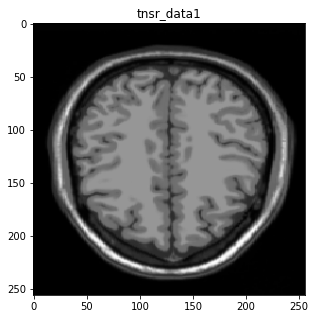

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(samp_tr1[0].numpy()[:, :, 0] * 0.5 + 0.3, cmap='gray')
plt.title('tnsr_data1')
plt.show()


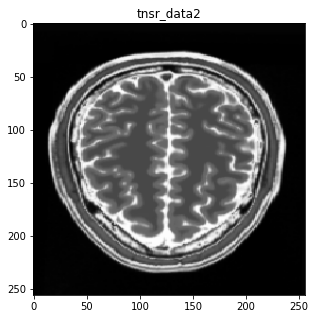

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(samp_tr2[0].numpy()[:, :, 0] * 0.5 + 0.3, cmap='gray')
plt.title('tnsr_data2')
plt.show()


##Model Building 

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [ ]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Adding Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, 
                                      use_bias=False))
    # Adding Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Adding Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Adding Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, 
                                               padding='same',kernel_initializer=initializer, 
                                               use_bias=False))
    # Adding Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Adding Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

In [ ]:
def unet_generator():
   
    down_stack = [
      downsample(64, 4, apply_norm=False), 
      downsample(128, 4), 
      downsample(256, 4),  
      downsample(512, 4),  
      downsample(512, 4), 
      downsample(512, 4),  
      downsample(512, 4),   
    ]
                  #create a stack of downsample models
    up_stack = [
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4, apply_dropout=True),  
      upsample(512, 4),  
      upsample(256, 4),  
      upsample(128, 4),  
      upsample(64, 4),  
               ] #create a stack of upsample models
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') 
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 1])
    x = inputs
    # Downsampling through the model
    skips = []  
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator_g = unet_generator()
generator_f = unet_generator()
generator_g.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 sequential_34 (Sequential)     (None, None, None,   1024        ['input_3[0][0]']                
                                64)                                                               
                                                                                                  
 sequential_35 (Sequential)     (None, None, None,   131328      ['sequential_34[0][0]']          
                                128)                                                        

In [ ]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    x = inp
    down1 = downsample(64, 4,  False)(x)  #to downsample X
    down2 = downsample(128, 4)(down1)     #to downsample down1
    down3 = downsample(256, 4)(down2)     #to downsample down2
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
  
    return tf.keras.Model(inputs=inp, outputs=last) #create the model using input & output layer

In [ ]:
discriminator_x = discriminator()
discriminator_y = discriminator()

discriminator_x.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, None, None, 1)]   0         
                                                                 
 sequential_62 (Sequential)  (None, None, None, 64)    1024      
                                                                 
 sequential_63 (Sequential)  (None, None, None, 128)   131328    
                                                                 
 sequential_64 (Sequential)  (None, None, None, 256)   524800    
                                                                 
 zero_padding2d_4 (ZeroPaddi  (None, None, None, 256)  0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, None, None, 512)   2097152   
                                                           

# **Model** **Training**

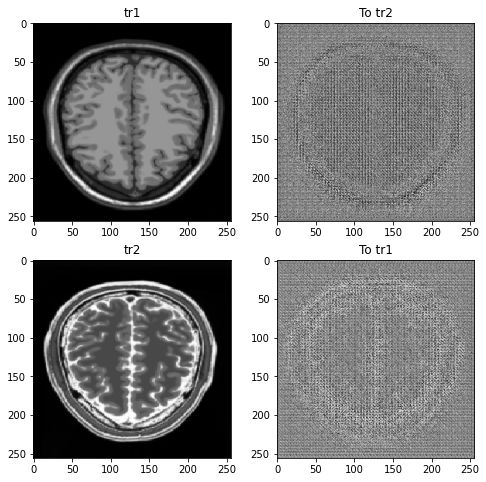

In [ ]:
to_tr2 = generator_g(samp_tr1)

to_tr1 = generator_f(samp_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [samp_tr1, to_tr2, samp_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()


In [ ]:
#LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
#calculating discriminator loss by summing the real and generated
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real) 
    generated_loss = loss_obj(tf.zeros_like(generated), generated) 
    total_disc_loss = real_loss + generated_loss 
    return total_disc_loss * 0.5


In [ ]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image)) 
    return 10.0 * loss1


In [ ]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * loss

In [ ]:
# Optimizer with learning rate 0.0001 for generator and discriminator - 2e-4
generator_g_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

In [ ]:
EPOCHS = 25

checkpoint_path = './checkpoints'  
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [ ]:
def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(8, 8))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
      # Generator G translates X -> Y
      # Generator F translates Y -> X.
      fake_y = generator_g(real_x, training=True)  #to generate images using Generator_g on real_x
      cycled_x = generator_f(fake_y, training=True) #to generate images susiing Generator_f on fake_y
      
      fake_x =  generator_f(real_y, training=True) #to generate images using Generator_f on real_y
      cycled_y = generator_g(fake_x, training=True) #to generate images using Generator_g on fake_x
      
      # same_x and same_y are used for identity loss.
      same_x = generator_f(real_x, training=True) #to generate images using Generator_f on real_x
      same_y = generator_g(real_y, training=True) #to generate images using Generator_g on real_y
      
      disc_real_x =  discriminator_x(real_x, training=True) #discriminate images using Discriminator_x on real_x
      disc_real_y = discriminator_y(real_y, training=True) #discriminate images using Discriminator_y on real_y
      
      disc_fake_x = discriminator_x(fake_x, training=True) #discriminate images using Discriminator_x on fake_x
      disc_fake_y = discriminator_y(fake_y, training=True) #discriminate images using Discriminator_y on fake_y
      
      # calculating the loss
      gen_g_loss = generator_loss(disc_fake_y) # calculate the generator_loss for disc_fake_
      gen_f_loss = generator_loss(disc_fake_x) # calculate the generator_loss for disc_fake_X 
      
      total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
      #calculate the total cycle loss
      
      # Total generator loss = adversarial loss + cycle loss
      total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
      total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
      
      disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) # discriminator_loss for disc_fake_x wrt disc_real_x
      disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y) # discriminator_loss foor disc_fake_y wrt disc_real_y
      
  # gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                      generator_g.trainable_variables) 
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                      generator_f.trainable_variables) 
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                          discriminator_x.trainable_variables) 
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                          discriminator_y.trainable_variables)

  
  # Apply the gradients to the optimizer
  
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,discriminator_y.trainable_variables))

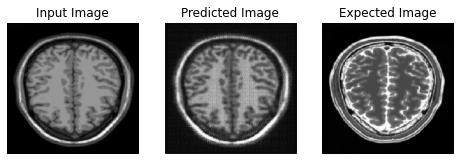

Saving checkpoint for epoch 0 at ./checkpoints/ckpt-1


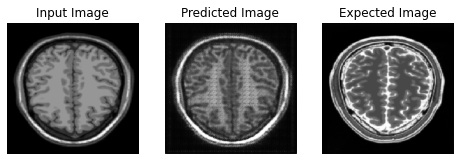

Saving checkpoint for epoch 1 at ./checkpoints/ckpt-2


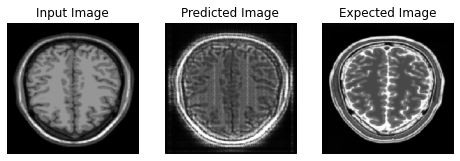

Saving checkpoint for epoch 2 at ./checkpoints/ckpt-3


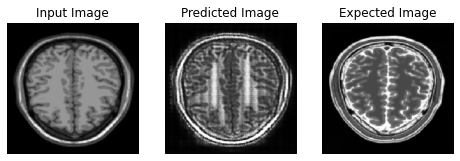

Saving checkpoint for epoch 3 at ./checkpoints/ckpt-4


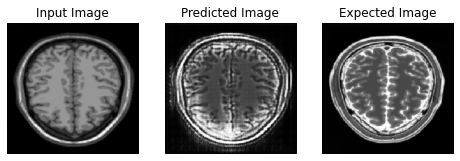

Saving checkpoint for epoch 4 at ./checkpoints/ckpt-5


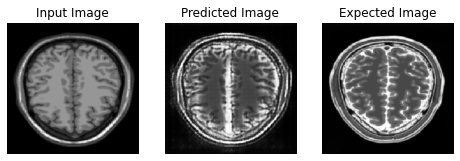

Saving checkpoint for epoch 5 at ./checkpoints/ckpt-6


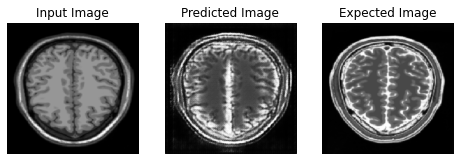

Saving checkpoint for epoch 6 at ./checkpoints/ckpt-7


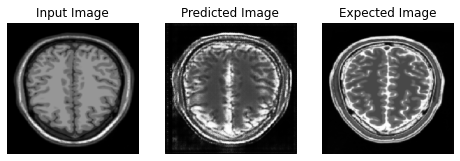

Saving checkpoint for epoch 7 at ./checkpoints/ckpt-8


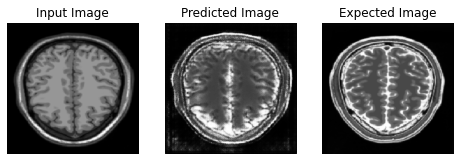

Saving checkpoint for epoch 8 at ./checkpoints/ckpt-9


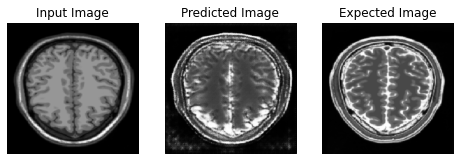

Saving checkpoint for epoch 9 at ./checkpoints/ckpt-10


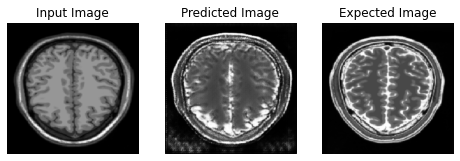

Saving checkpoint for epoch 10 at ./checkpoints/ckpt-11


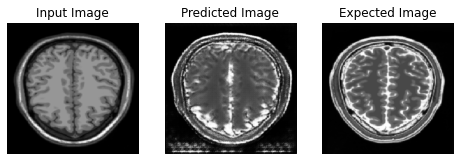

Saving checkpoint for epoch 11 at ./checkpoints/ckpt-12


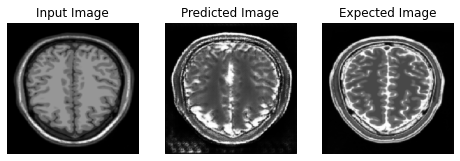

Saving checkpoint for epoch 12 at ./checkpoints/ckpt-13


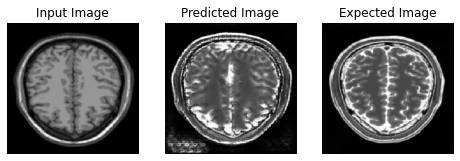

Saving checkpoint for epoch 13 at ./checkpoints/ckpt-14


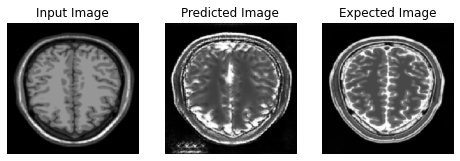

Saving checkpoint for epoch 14 at ./checkpoints/ckpt-15


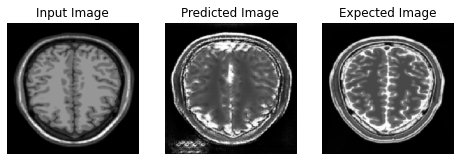

Saving checkpoint for epoch 15 at ./checkpoints/ckpt-16


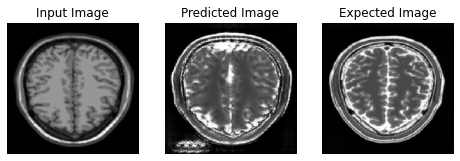

Saving checkpoint for epoch 16 at ./checkpoints/ckpt-17


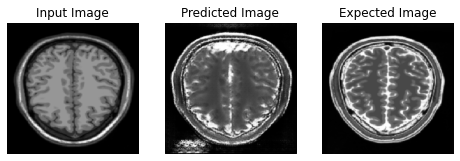

Saving checkpoint for epoch 17 at ./checkpoints/ckpt-18


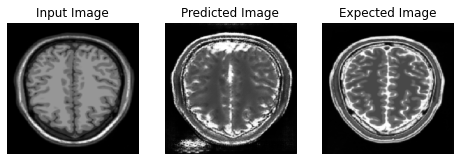

Saving checkpoint for epoch 18 at ./checkpoints/ckpt-19


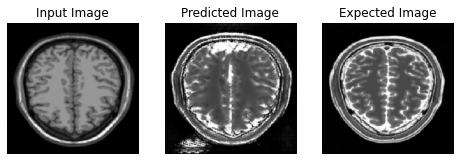

Saving checkpoint for epoch 19 at ./checkpoints/ckpt-20


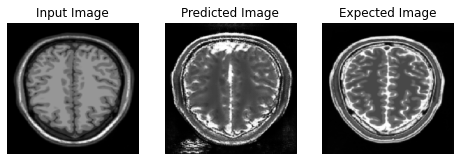

Saving checkpoint for epoch 20 at ./checkpoints/ckpt-21


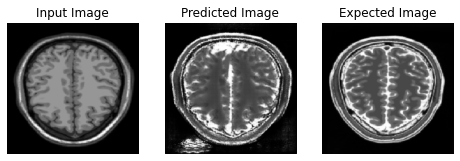

Saving checkpoint for epoch 21 at ./checkpoints/ckpt-22


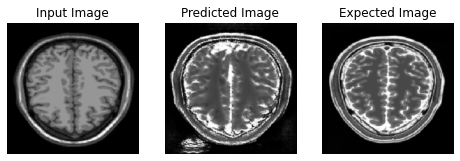

Saving checkpoint for epoch 22 at ./checkpoints/ckpt-23


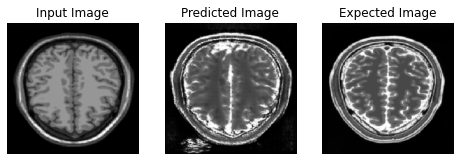

Saving checkpoint for epoch 23 at ./checkpoints/ckpt-24


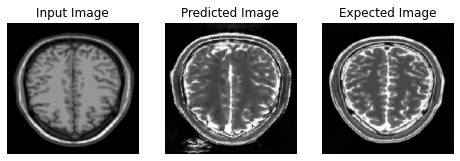

Saving checkpoint for epoch 24 at ./checkpoints/ckpt-25


In [ ]:
for epoch in range(EPOCHS):
    for image_x, image_y in tf.data.Dataset.zip((tnsr_data1, tnsr_data2)):
        train_step(image_x, image_y)
    generate_images(generator_g, samp_tr1, samp_tr2)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)


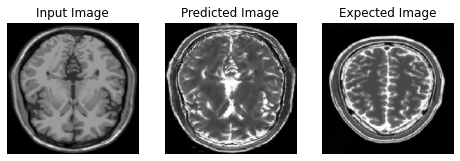

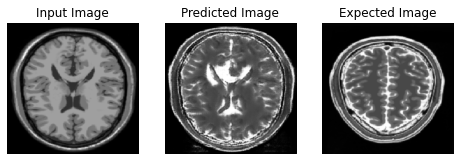

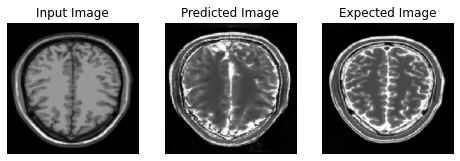

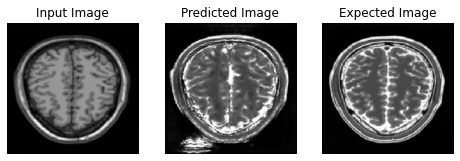

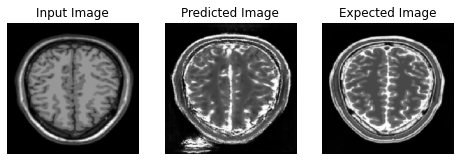

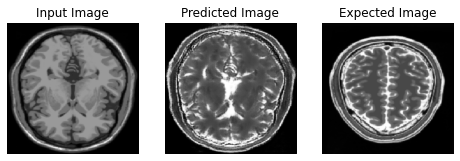

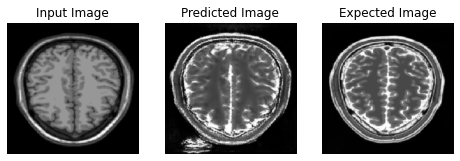

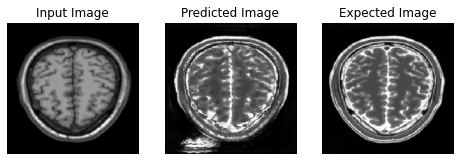

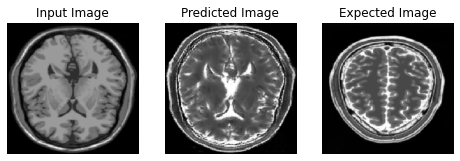

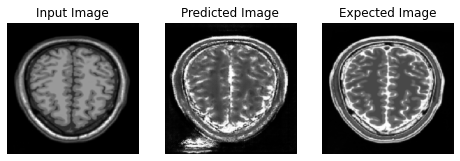

In [ ]:
# Run the trained model on the test dataset
for inp in tnsr_data1.take(10):
    generate_images(generator_g, inp, samp_tr2)